# Temat Projektu: Klasyfikacja tekstu, detekcja fake-newsów
### Autor: Jerzy Muszyński


## Część 1: Podejście klasyczne (Baseline) - TF-IDF + Regresja Logistyczna

**Cel notatnika:**
W tej części projektu ustanowimy punkt odniesienia (baseline) dla bardziej zaawansowanych modeli LLM. Wykorzystamy klasyczne metody przetwarzania języka naturalnego (NLP):
1.  **Reprezentacja tekstu:** TF-IDF (Term Frequency-Inverse Document Frequency).
2.  **Model klasyfikacyjny:** Regresja Logistyczna.
3.  **Optymalizacja:** Przeszukiwanie siatki (Grid Search) w celu doboru hiperparametrów.

Analiza ta pozwoli ocenić, jak trudny jest dany zbiór danych i ile zyskujemy, stosując kosztowne obliczeniowo modele głębokie w kolejnych etapach.

In [ ]:
!nvidia-smi

Sat Jan 31 13:07:54 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             46W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## 1. Konfiguracja środowiska i ładowanie danych
Instalacja niezbędnych bibliotek oraz wstępna analiza zbioru danych. Sprawdzimy balans klas (czy zbiór jest zrównoważony) oraz przykładowe wpisy, aby zrozumieć strukturę danych.

In [ ]:
!pip -q install datasets scikit-learn umap-learn matplotlib torchmetrics evaluate peft bitsandbytes trl accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 48.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import gc
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from datasets import load_dataset
import umap
import random
from itertools import product

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.9.0+cu126


In [ ]:
is_cuda = torch.cuda.is_available()
print(f"GPU Availability: {is_cuda}")

if is_cuda:
  print(f"GPU type: {torch.cuda.get_device_name(0)}")
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

GPU Availability: True
GPU type: NVIDIA A100-SXM4-40GB


In [ ]:
def cleanup():
    if 'model' in globals():
        del globals()['model']
    if 'tokenizer' in globals():
        del globals()['tokenizer']
    if 'trainer' in globals():
        del globals()['trainer']

    gc.collect()
    torch.cuda.empty_cache()
    print("Memory cleaned.")

#### Funkcje Pomocnicze do Ewaluacji

Aby rzetelnie ocenić model, nie wystarczy sama "celność" (Accuracy). Definiujemy funkcje, które pokażą nam pełny obraz:

1.  **`calculate_metrics_core`**: Oblicza zestaw czterech metryk:
    * *Accuracy:* Ogólna skuteczność.
    * *Precision:* Jak pewny jest model, gdy mówi "Fake"?
    * *Recall:* Ile faktycznych fake'ów udało się wyłapać?
    * *F1:* Średnia wyważona precyzji i czułości.
2.  **`show_report_and_cm`**: Generuje wizualny raport:
    * *Classification Report:* Tabela z liczbami.
    * *Confusion Matrix (Macierz Pomyłek):* Niebieski wykres, który pokazuje, ile razy model pomylił prawdę z fałszem (i odwrotnie). Pozwala to zobaczyć, czy model jest "stronniczy" w jedną stronę.

In [ ]:
SEED = random.seed(43)
LABEL_NAMES = ["Real", "Fake"]

In [ ]:
def calculate_metrics_core(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    acc = accuracy_score(y_true, y_pred)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
def show_report_and_cm(y_true, y_pred, title_prefix=""):
    print(f"\n=== Classification report ({title_prefix}) ===")
    print(classification_report(
        y_true, y_pred,
        target_names=LABEL_NAMES,
        digits=3
    ))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL_NAMES)

    disp.plot(colorbar=False, cmap="Blues")
    plt.tight_layout()
    plt.title(f"Confusion matrix – {title_prefix}")
    plt.show()

In [ ]:
def show_visualization_tfidf(X, y, n_probes, title_prefix=""):
  X_subset = X[:n_probes]
  y_subset = y[:n_probes]

  svd = TruncatedSVD(n_components=50, random_state=SEED)
  X_50 = svd.fit_transform(X_subset)

  tsne = TSNE(n_components=2, random_state=SEED, init="pca", learning_rate="auto")
  X_2 = tsne.fit_transform(X_50)

  plt.figure(figsize=(7,5))
  for lab in [0,1]:
      idx = (y_subset == lab)
      plt.scatter(X_2[idx,0], X_2[idx,1], s=10, alpha=0.7, label=LABEL_NAMES[lab])

  plt.legend()
  plt.title(f"tSNE on TF-IDF representation - {title_prefix}")
  plt.show()

In [ ]:
ds = load_dataset("ErfanMoosaviMonazzah/fake-news-detection-dataset-English")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/487 [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/78.4M [00:00<?, ?B/s]

validation.tsv:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8267 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'subject', 'date', 'label'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'subject', 'date', 'label'],
        num_rows: 6000
    })
    test: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'subject', 'date', 'label'],
        num_rows: 8267
    })
})

## 1. Analiza Eksploracyjna Danych (EDA)
Zanim zaczniemy trenować model, musimy zrozumieć, na czym pracujemy.

**Sprawdzenie balansu klas:**
Rysujemy histogram, aby zobaczyć, czy mamy tyle samo artykułów prawdziwych ("Real") co fałszywych ("Fake").
* Jeśli słupki są równe – to świetnie (zbiór zbalansowany).
* Jeśli jeden słupek jest znacznie wyższy – musielibyśmy zastosować dodatkowe techniki, bo model "nauczyłby się" zgadywać częstszą klasę.

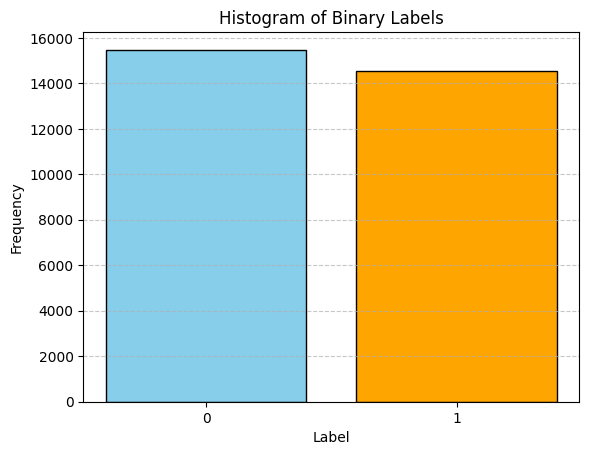

In [ ]:
unique_labels, counts = np.unique(ds["train"]['label'], return_counts=True)

plt.bar(unique_labels, counts, color=['skyblue', 'orange'], edgecolor='black')
plt.title('Histogram of Binary Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(unique_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
example = ds["train"][random.randint(0, len(ds["train"]))]
print(example)
print(f"Title: {example['title']}")
print(f"Content: {example['text']}")
print(f"Label: {"Real" if example['label'] == 1 else "Fake"}")

{'Unnamed: 0': 20280, 'title': 'BIKERS FOR TRUMP: “Not Going To Put Up With” Violent Leftists Disrupting Cleveland GOP Convention…Will Protect Delegates “Right To Peacefully Assemble”', 'text': 'Veterans are the backbone of the biker community We are patriots We love our cops The antithesis of the Black Lives Matter radicals Breitbart Exclusive: A large group of patriotic motorcycle enthusiasts will be among the visitors to Cleveland Ohio next week for the Republican National Committee meeting that will nominate business mogul Donald Trump to be the Republican nominee for President of the United States.Bikers for Trump aren t going to Cleveland looking to cause trouble but will be on hand to counter thousands of professional leftwing agitators planning to disrupt the Republican nominating convention. We will be there to make sure that the delegates are allowed to exercise their right to peacefully assemble,  Bikers for Trump organizer Chris Cox told Breitbart News in an exclusive inter

## 2. Inżynieria Cech (Feature Engineering)

Surowe dane zawierają osobno **tytuł** i **treść** artykułu.
* **Problem:** Fake newsy często mają sensacyjne, mylące tytuły ("clickbait"), które są silną wskazówką dla modelu. Jeśli podamy modelowi samą treść, stracimy tę informację.
* **Rozwiązanie:** Tworzymy nową kolumnę `input_text`, w której sklejamy tytuł z treścią. To będzie nasz pełny tekst wejściowy do klasyfikacji.

In [ ]:
def add_input_text(data_point):
  title = data_point.get("title", "")
  text = data_point.get("text", "")
  data_point["input_text"] = (title.strip() + "\n " + text.strip()).strip()
  return data_point

In [ ]:
ds = ds.map(add_input_text)
ds["train"][0]["input_text"]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8267 [00:00<?, ? examples/s]

"Ex-CIA head says Trump remarks on Russia interference 'disgraceful'\n Former CIA director John Brennan on Friday criticized as “disgraceful” President Donald Trump’s efforts to play down U.S. intelligence agencies’ assessment that Russia meddled in the 2016 U.S. election. Trump’s administration has been dogged by investigations into allegations of Russian interference in last year’s U.S. presidential election and possible ties with his campaign team. Speaking one day before his first meeting with Russian President Vladimir Putin in Hamburg earlier this month, Trump said he suspected Russian interference in the election but that no one knows for sure. “These types of comments are just disgraceful ... and the person who said them should be ashamed of himself,” said Brennan, CIA chief under former President Barack Obama, at the Aspen Security Forum. Special Counsel Robert Mueller and several U.S. congressional committees are investigating whether Russia interfered in the election and col

## 3. Eksperyment: Strojenie Hiperparametrów (Grid Search)

Nie wiemy z góry, jakie ustawienia TF-IDF będą najlepsze. Czy brać pod uwagę tylko pojedyncze słowa? A może pary słów? Czy słownik powinien mieć 10 tysięcy słów, czy 50 tysięcy?

Zamiast zgadywać, przeprowadzimy eksperyment typu **Grid Search** (Przeszukiwanie Siatki). Przetestujemy każdą możliwą kombinację poniższych parametrów:

1.  **`ngram_range`**:
    * `(1,1)`: Model widzi tylko pojedyncze słowa (unigramy), np. "nie", "dobry".
    * `(1,2)`: Model widzi też pary słów (bigramy), np. "nie dobry". To pozwala wyłapać proste zaprzeczenia.
2.  **`max_features`**: Ograniczenie wielkości słownika. Czy bierzemy 10k, 30k czy 50k najczęstszych słów?
3.  **`min_df`**: Odrzucamy słowa, które wystąpiły w mniej niż X dokumentach (usuwamy literówki i unikaty).
4.  **`max_df`**: Odrzucamy słowa, które występują w ponad X% dokumentów (usuwamy słowa zbyt pospolite, które nie niosą informacji).

Dla każdej kombinacji wytrenujemy model na zbiorze treningowym i sprawdzimy wynik na zbiorze walidacyjnym.

In [ ]:

param_grid = {
    "max_features": [10000, 30000, 50000],
    "ngram_range": [(1,1), (1,2)],
    "min_df": [2, 5, 10],
    "max_df": [0.8, 0.9, 0.95]
}
param_combinations = [
    dict(zip(param_grid.keys(), values))
    for values in product(*param_grid.values())
]

print(f"Combinations: {len(param_combinations)}")
for p in param_combinations:
    print(p)

Combinations: 54
{'max_features': 10000, 'ngram_range': (1, 1), 'min_df': 2, 'max_df': 0.8}
{'max_features': 10000, 'ngram_range': (1, 1), 'min_df': 2, 'max_df': 0.9}
{'max_features': 10000, 'ngram_range': (1, 1), 'min_df': 2, 'max_df': 0.95}
{'max_features': 10000, 'ngram_range': (1, 1), 'min_df': 5, 'max_df': 0.8}
{'max_features': 10000, 'ngram_range': (1, 1), 'min_df': 5, 'max_df': 0.9}
{'max_features': 10000, 'ngram_range': (1, 1), 'min_df': 5, 'max_df': 0.95}
{'max_features': 10000, 'ngram_range': (1, 1), 'min_df': 10, 'max_df': 0.8}
{'max_features': 10000, 'ngram_range': (1, 1), 'min_df': 10, 'max_df': 0.9}
{'max_features': 10000, 'ngram_range': (1, 1), 'min_df': 10, 'max_df': 0.95}
{'max_features': 10000, 'ngram_range': (1, 2), 'min_df': 2, 'max_df': 0.8}
{'max_features': 10000, 'ngram_range': (1, 2), 'min_df': 2, 'max_df': 0.9}
{'max_features': 10000, 'ngram_range': (1, 2), 'min_df': 2, 'max_df': 0.95}
{'max_features': 10000, 'ngram_range': (1, 2), 'min_df': 5, 'max_df': 0.8}
{

In [ ]:
def run_tfidf_experiment(train_dataset, val_dataset, **vectorizer_kwargs):

  X_train = train_dataset["input_text"]
  y_train = np.array(train_dataset["label"])

  X_val  = val_dataset["input_text"]
  y_val  = np.array(val_dataset["label"])

  vectorizer = TfidfVectorizer(
    **vectorizer_kwargs
  )

  for k, v in vectorizer_kwargs.items():
    print(f"   {k} = {v}")


  train_features = vectorizer.fit_transform(X_train)
  val_features = vectorizer.transform(X_val)

  clf = LogisticRegression(
    max_iter=2000,
    n_jobs=None,
    class_weight=None
  )

  clf.fit(train_features, y_train)

  pred = clf.predict(val_features)

  metrics = calculate_metrics_core(y_val, pred)

  return metrics

In [ ]:
results = []

for params in param_combinations:
  print(f"Parameters: {params}")
  metrics = run_tfidf_experiment(
    ds["train"],
    ds["validation"],
    **params
  )
  results.append({**params, **metrics})

Parameters: {'max_features': 10000, 'ngram_range': (1, 1), 'min_df': 2, 'max_df': 0.8}
   max_features = 10000
   ngram_range = (1, 1)
   min_df = 2
   max_df = 0.8
Parameters: {'max_features': 10000, 'ngram_range': (1, 1), 'min_df': 2, 'max_df': 0.9}
   max_features = 10000
   ngram_range = (1, 1)
   min_df = 2
   max_df = 0.9
Parameters: {'max_features': 10000, 'ngram_range': (1, 1), 'min_df': 2, 'max_df': 0.95}
   max_features = 10000
   ngram_range = (1, 1)
   min_df = 2
   max_df = 0.95
Parameters: {'max_features': 10000, 'ngram_range': (1, 1), 'min_df': 5, 'max_df': 0.8}
   max_features = 10000
   ngram_range = (1, 1)
   min_df = 5
   max_df = 0.8
Parameters: {'max_features': 10000, 'ngram_range': (1, 1), 'min_df': 5, 'max_df': 0.9}
   max_features = 10000
   ngram_range = (1, 1)
   min_df = 5
   max_df = 0.9
Parameters: {'max_features': 10000, 'ngram_range': (1, 1), 'min_df': 5, 'max_df': 0.95}
   max_features = 10000
   ngram_range = (1, 1)
   min_df = 5
   max_df = 0.95
Parame

### Analiza wyników eksperymentu

Poniższa tabela przedstawia wyniki dla każdej sprawdzonej konfiguracji.
Sortujemy je, aby znaleźć "Zwycięzcę" – zestaw parametrów, który dał najwyższą dokładność (Accuracy) i F1-score. To właśnie te parametry wykorzystamy w finalnym modelu.

In [ ]:
df = pd.DataFrame(results)
df.head(10)

,max_features,ngram_range,min_df,max_df,accuracy,precision,recall,f1
0,10000,"(1, 1)",2,0.80,0.983000,0.976263,0.989007,0.982594
1,10000,"(1, 1)",2,0.90,0.983667,0.976618,0.990038,0.983282
2,10000,"(1, 1)",2,0.95,0.983333,0.977574,0.988320,0.982918
3,10000,"(1, 1)",5,0.80,0.983000,0.976263,0.989007,0.982594
4,10000,"(1, 1)",5,0.90,0.983333,0.976279,0.989694,0.982941
5,10000,"(1, 1)",5,0.95,0.983333,0.977574,0.988320,0.982918
6,10000,"(1, 1)",10,0.80,0.982833,0.976255,0.988664,0.982420
7,10000,"(1, 1)",10,0.90,0.983500,0.976610,0.989694,0.983109
8,10000,"(1, 1)",10,0.95,0.983333,0.977574,0.988320,0.982918
9,10000,"(1, 2)",2,0.80,0.986333,0.981614,0.990381,0.985978


W poniższej komórce znajduje się zestaw hiperparametrów "zwycięzcy", które wykorzystamy do finalnej ewaluacji

In [ ]:
best_params = df.iloc[0]
best_params

,0
max_features,10000
ngram_range,"(1, 1)"
min_df,2
max_df,0.8
accuracy,0.983
precision,0.976263
recall,0.989007
f1,0.982594


In [ ]:
best_params.to_dict()
best_params = best_params.drop("precision")
best_params = best_params.drop("f1")
best_params = best_params.drop("recall")
best_params = best_params.drop("accuracy")


## 5. Finalny Trening i Test

Mamy już wybrane najlepsze parametry (z poprzedniego kroku). Teraz:
1.  Tworzymy wektoryzator TF-IDF z tymi **optymalnymi ustawieniami**.
2.  Trenujemy model na zbiorze treningowym.
3.  **Weryfikacja Ostateczna:** Sprawdzamy działanie modelu na zbiorze **TESTOWYM**.
    * To kluczowy moment. Model nigdy wcześniej nie widział tych danych. Wynik na zbiorze testowym mówi nam, jak system poradzi sobie w prawdziwym świecie.

In [ ]:
X_train = ds["train"]["input_text"]
y_train = np.array(ds["train"]["label"])

X_test  = ds["test"]["input_text"]
y_test  = np.array(ds["test"]["label"])

X_val  = ds["validation"]["input_text"]
y_val  = np.array(ds["validation"]["label"])

vectorizer = TfidfVectorizer(
    **best_params.to_dict()
)

train_features = vectorizer.fit_transform(X_train)
test_features = vectorizer.transform(X_test)
val_features = vectorizer.transform(X_val)

clf = LogisticRegression(
    max_iter=2000,
    n_jobs=None,
    class_weight=None
)
clf.fit(train_features, y_train)

pred_train = clf.predict(train_features)
pred_test  = clf.predict(test_features)
pred_val   = clf.predict(val_features)


## 6. Szczegółowa Ewaluacja Modelu (Train vs Test)

W tej sekcji porównujemy wyniki modelu na zbiorze treningowym, walidacyjnym i testowym.

1.  **Macierz Pomyłek (Confusion Matrix):**
2.  **Detekcja Przeuczenia (Overfitting):**


=== Classification report (Training set) ===
              precision    recall  f1-score   support

        Fake      0.991     0.986     0.988     15478
        Real      0.985     0.991     0.988     14522

    accuracy                          0.988     30000
   macro avg      0.988     0.988     0.988     30000
weighted avg      0.988     0.988     0.988     30000



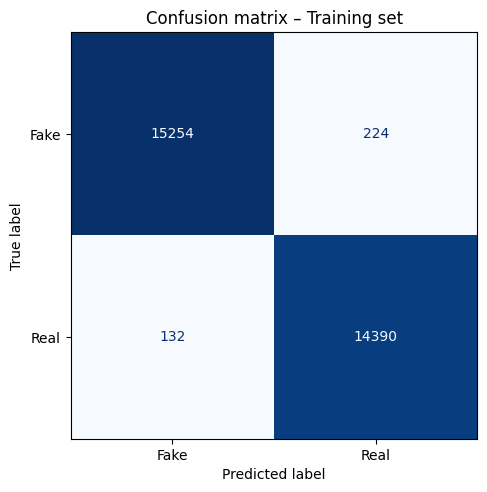


=== Classification report (Test set) ===
              precision    recall  f1-score   support

        Fake      0.986     0.979     0.983      4284
        Real      0.977     0.985     0.981      3983

    accuracy                          0.982      8267
   macro avg      0.982     0.982     0.982      8267
weighted avg      0.982     0.982     0.982      8267



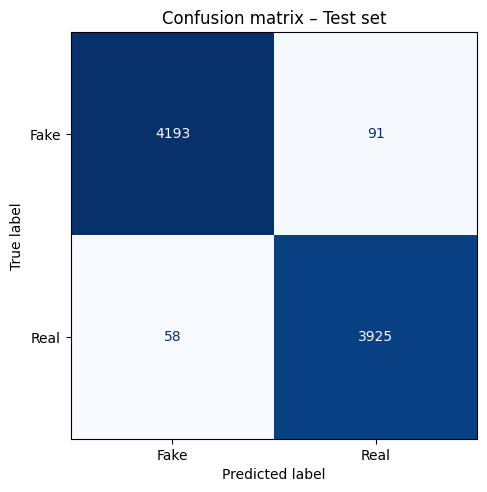


=== Classification report (Validation set) ===
              precision    recall  f1-score   support

        Fake      0.990     0.977     0.983      3089
        Real      0.976     0.989     0.983      2911

    accuracy                          0.983      6000
   macro avg      0.983     0.983     0.983      6000
weighted avg      0.983     0.983     0.983      6000



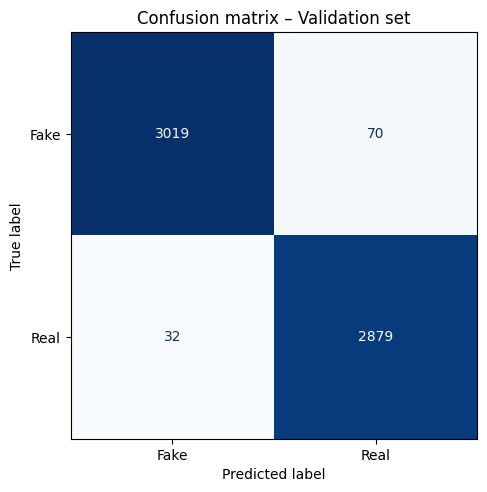

In [ ]:
show_report_and_cm(y_train, pred_train, "Training set")
show_report_and_cm(y_test,  pred_test,  "Test set")
show_report_and_cm(y_val, pred_val, "Validation set")

## 7. Wizualizacja Przestrzeni Cech (t-SNE / UMAP)

Chcemy "zajrzeć do środka" modelu i zobaczyć, jak postrzega on artykuły.

Ponieważ wektory TF-IDF mają tysiące wymiarów (tyle, ile słów w słowniku), nie da się ich narysować na kartce. Używamy techniki redukcji wymiarów (SVD + t-SNE), aby spłaszczyć te dane do 2 wymiarów (kropek na wykresie).

**Jak czytać wykres?**
* Każda kropka to jeden artykuł.
* **Kolor** oznacza prawdziwą etykietę (Fake/Real).
* Jeśli kolory tworzą **oddzielne wyspy** – model łatwo odróżnia prawdę od fałszu.
* Jeśli kolory są **wymieszane** jak "kasza z grochem" – model ma trudności, a same słowa kluczowe mogą nie wystarczyć do klasyfikacji.

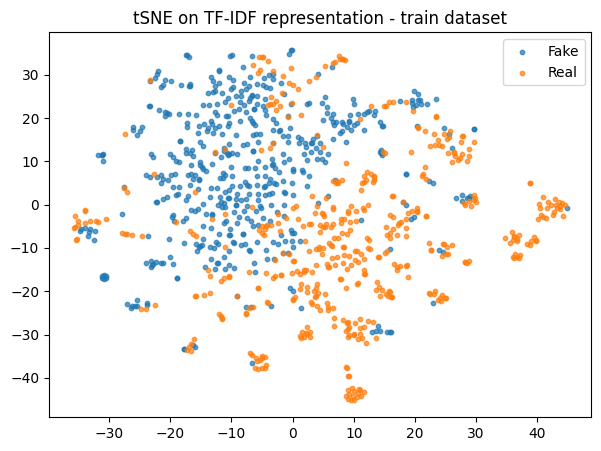

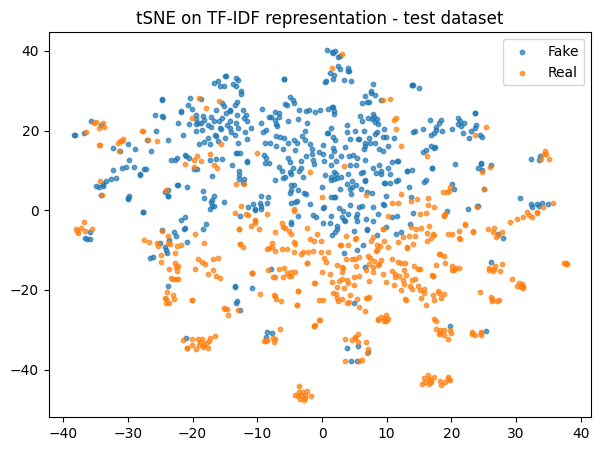

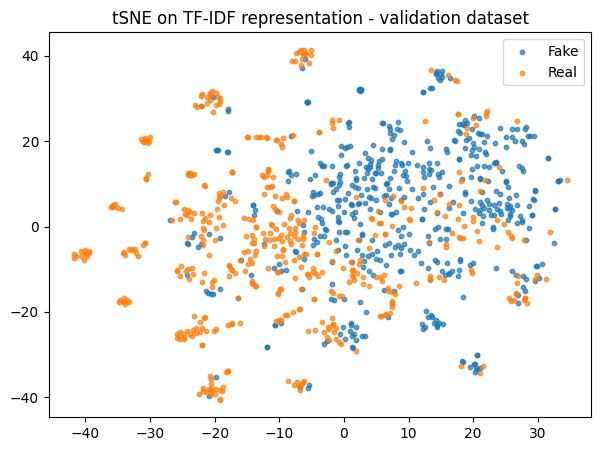

In [ ]:
show_visualization_tfidf(train_features, y_train, 1000, "train dataset")
show_visualization_tfidf(test_features, y_test, 1000, "test dataset")
show_visualization_tfidf(val_features, y_val, 1000, "validation dataset")

# Podsumowanie Części 1

W tym notatniku ustanowiliśmy **Baseline** (punkt odniesienia).
Zastosowanie klasycznej metody TF-IDF w połączeniu z Regresją Logistyczną pozwoliło na uzyskanie wyników widocznych powyżej.

**Wnioski:**
1.  Metoda ta jest szybka i interpretowalna (możemy sprawdzić, które słowa decydują o klasyfikacji).
2.  Jej głównym ograniczeniem jest brak zrozumienia kolejności słów i głębszego kontekstu (traktuje zdanie jak "worek słów").

W kolejnym notatniku (**Część 2**) sprawdzimy, czy zastosowanie modelu językowego typu Transformer (**DistilBERT**), który czyta tekst w obie strony i rozumie kontekst, pozwoli poprawić te wyniki.